In [1]:
import numpy as np
from numpy import ndarray
import torch
from torch import Tensor, nn
from torchvision.models import resnet50, ResNet50_Weights
from PIL import Image
from PIL.Image import Image as Img
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import requests
from io import BytesIO
from skimage.segmentation import slic, mark_boundaries
from sklearn.linear_model import Lasso
from torch.utils.data import DataLoader
from sklearn.metrics import pairwise_distances

warnings.filterwarnings('ignore')

## Part 0: Loading a pre-trained vision model

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2).to(DEVICE)
preprocess = ResNet50_Weights.IMAGENET1K_V2.transforms().to(DEVICE)
classes = np.array(ResNet50_Weights.IMAGENET1K_V2.meta['categories'])
model.eval();

In [3]:
def load_img_from_url(url:str):
    response = requests.get(url)
    return Image.open(BytesIO(response.content))

In [4]:
def img_to_preprocessed_tensor(img: Image) -> Tensor:
    img_tensor = torch.tensor(np.asanyarray(img)).T
    return preprocess(img_tensor).unsqueeze(0)

In [5]:
def normalize_image(img):
    return (img-img.min()) /(img.max()-img.min())

In [6]:
def plot_topk_classes(output: Tensor, k=3):
    plt.figure(figsize=(8,5))
    [values], [indices] = output.topk(k)
    classes[output.topk(3).indices]
    sns.barplot(x = classes[indices.detach()], y=values.detach().numpy())
    plt.title(f'Top {k} Predicted Classes')
    plt.ylabel('$f(x)$')
    plt.tight_layout();

In [10]:
def plot_multi_images_pipeline(images: list[Image.Image], n_classes=3):
    images_labels = []
    preprocesses_images = list(map(img_to_preprocessed_tensor, images))
    _, axes = plt.subplots(len(images),3, figsize=(12,3 * len(images)))
    with torch.no_grad():
        for i, (img, img_preprocessed) in enumerate(zip(images, preprocesses_images)):
            axes[i,0].imshow(img)
            axes[i,1].imshow(normalize_image(img_preprocessed.squeeze(0).T))
            img_preprocessed = img_preprocessed.to(DEVICE)
            output = model(img_preprocessed)
            [values], [indices] = output.topk(n_classes)
            sns.barplot(x = classes[indices.cpu()], y=values.cpu().numpy(), ax=axes[i,2]).tick_params(labelsize=8)
            images_labels.append(dict(zip(classes[indices.cpu()],indices.cpu().numpy())))
            axes[i,0].set_title('Original Image')
            axes[i,1].set_title('Preprocessed Image')
            axes[i,2].set_title(f'Top {n_classes} predicted classes')
        plt.tight_layout()
        plt.show();
    return images_labels

In [8]:
cats = load_img_from_url('https://www.hepper.com/wp-content/uploads/2021/08/bengal-and-siamese-cats-side-by-side.jpg')
balls = load_img_from_url('https://baseballtrainingworld.com/wp-content/uploads/2022/11/Baseball-Basketball-balls-1024x576.jpg')
dog = load_img_from_url('https://www.thesun.co.uk/wp-content/uploads/2022/08/NINTCHDBPICT000755594952.jpg')


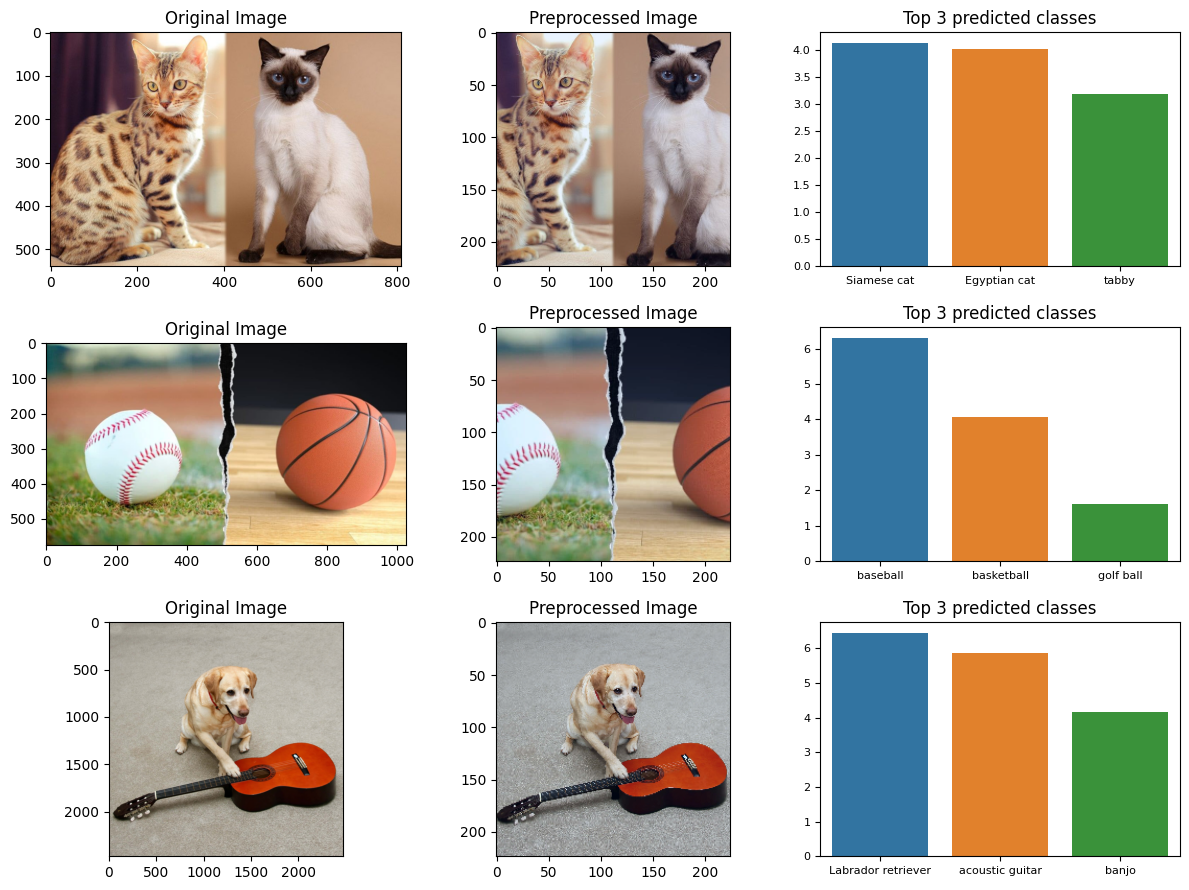

In [11]:
images_labels = plot_multi_images_pipeline([cats, balls, dog], n_classes=3);

## Part 1: LIME

In [12]:
class LIME:
    def __init__(self, model: nn.Module) -> None:
        self.model = model
        self.model.eval()
        self.transformed_images = []


    def fit(self, photo: Img, labels: list[int], n_samples=500, n_segments=20, alpha=0.001, sigma=1):
        self.transformed_images = []
        preprocessed_image = img_to_preprocessed_tensor(photo).squeeze().T
        segments, samples = self._generate_segments_and_samples(preprocessed_image, n_segments, n_samples)
        permuted_images = self._generate_perturbed_images(preprocessed_image, segments, samples)
        labels_scores = self._get_labels_scores(permuted_images, labels)
        pi = self._get_sample_weights(segments, samples, sigma)
        for i in range(len(labels)):
            focused_image = self._run_lasso_on_label(preprocessed_image.clone(), samples, labels_scores[:,[i]], segments, alpha, pi)
            self.transformed_images.append(focused_image)

    def transform(self):
        assert len(self.transformed_images) > 0, "Must fit model first"
        return self.transformed_images
    

    def fit_transform(self, photo: Img, labels: list[int], n_samples=500, n_segments=20, alpha=0.001, sigma=1):
        self.fit(photo, labels, n_samples, n_segments, alpha, sigma)
        return self.transform()


    def _run_lasso_on_label(self, image: Tensor, samples: ndarray, label_scores: ndarray, segments: ndarray, alpha: float, pi: ndarray):
        lasso = Lasso(alpha=alpha)
        lasso.fit(samples, label_scores, pi)
        top_superPixels = np.argwhere(lasso.coef_ >0)
        mask = np.isin(segments, top_superPixels)
        image[~mask] = 0
        image = normalize_image(image)

        return image


    def _get_labels_scores(self, permuted_images: Tensor, labels: list[int]) -> ndarray:
        dataloader = DataLoader(permuted_images, batch_size=16, shuffle=False, num_workers=2)
        scores = torch.empty(0, dtype=int).to(DEVICE)
        with torch.no_grad():
            for batch in dataloader:
                batch = batch.to(DEVICE)
                output = self.model(batch)
                v = output[:,labels]
                scores = torch.cat([scores, v])
                
        return scores.cpu().numpy() 


    def _generate_perturbed_images(self, image: Tensor, segments: ndarray, samples: ndarray) -> Tensor:
        images = np.apply_along_axis(self._create_perturbed_image, axis=1, arr=samples, image=image, segments=segments)
        return torch.tensor(images.transpose(0,3,1,2))


    def _generate_segments_and_samples(self, image: Tensor, n_segments: int, n_samples: int) -> tuple[ndarray, ndarray]:
        segments = slic(image, n_segments=n_segments) - 1
        n_real_segments = len(np.unique(segments))
        samples = np.random.randint(2, size=(n_samples,n_real_segments))

        return segments, samples


    def _get_sample_weights(self, segments: ndarray, samples: ndarray, sigma: float):
        n_segments = len(np.unique(segments))
        original_image_sample = np.ones(n_segments)[np.newaxis,:]
        distances = pairwise_distances(samples, original_image_sample, metric='cosine').ravel()

        return self._similarity_func(distances, sigma)


    def _create_perturbed_image(self, sample: ndarray, image: Tensor, segments: ndarray):
        mask = np.isin(segments, np.argwhere(sample))
        image = image.clone()
        image[~mask] = 0
        return image


    def _similarity_func(self, distances: ndarray, sigma: float):
        return np.sqrt(np.exp(-(distances**2)/sigma**2))
    

In [13]:
lime = LIME(model)

In [150]:
top_cats_labels = list(images_labels[0].values())
results = lime.fit_transform(cats, top_cats_labels, n_samples=500, n_segments=20, alpha=0.07)

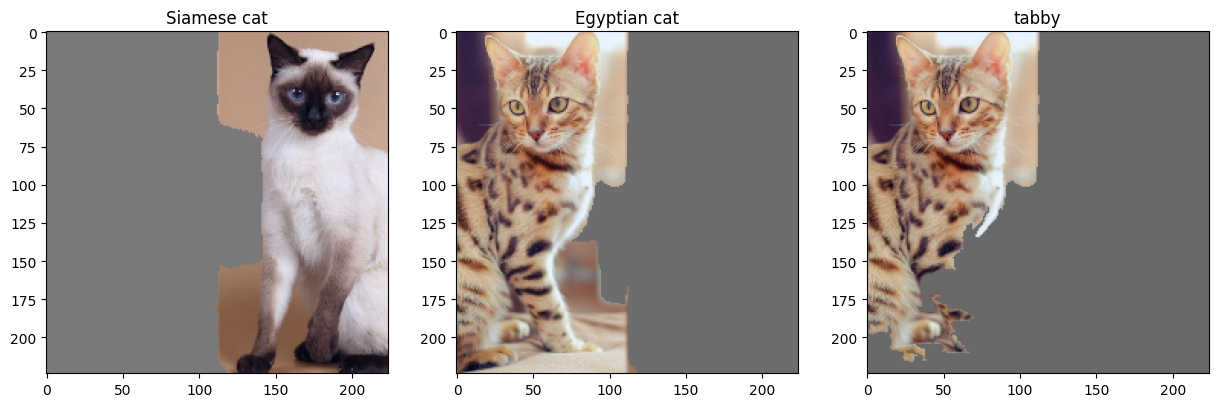

In [151]:
fig, ax = plt.subplots(1,len(top_cats_labels), figsize = (15,6))
for i, (label, index) in enumerate(images_labels[0].items()):
    ax[i].set_title(label)
    ax[i].imshow(results[i]);

In [152]:
top_balls_labels = list(images_labels[1].values())
results = lime.fit_transform(balls, top_balls_labels, n_samples=500, n_segments=20, alpha=0.1)

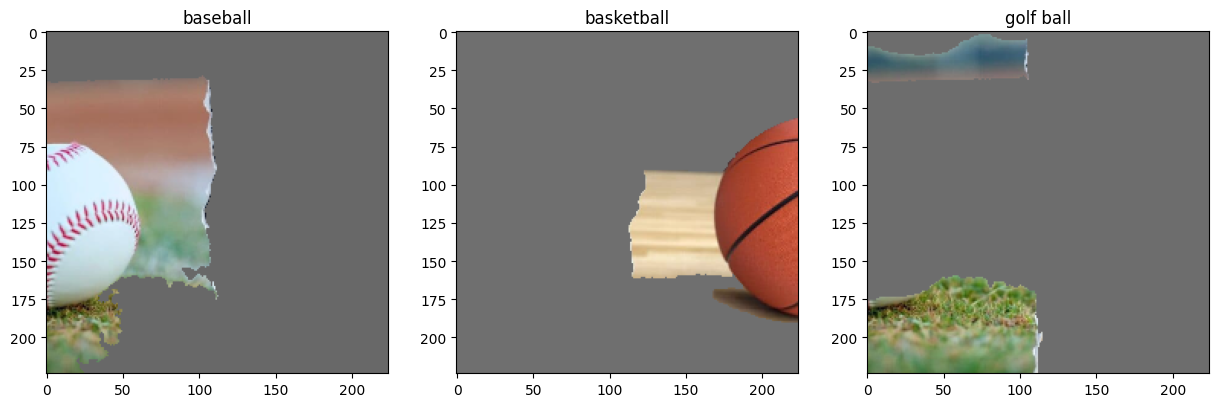

In [153]:
fig, ax = plt.subplots(1,len(top_balls_labels), figsize = (15,6))
for i, (label, index) in enumerate(images_labels[1].items()):
    ax[i].set_title(label)
    ax[i].imshow(results[i]);

In [40]:
top_dog_labels = list(images_labels[2].values())
results = lime.fit_transform(dog, top_dog_labels, n_samples=500, n_segments=20, alpha=0.15)

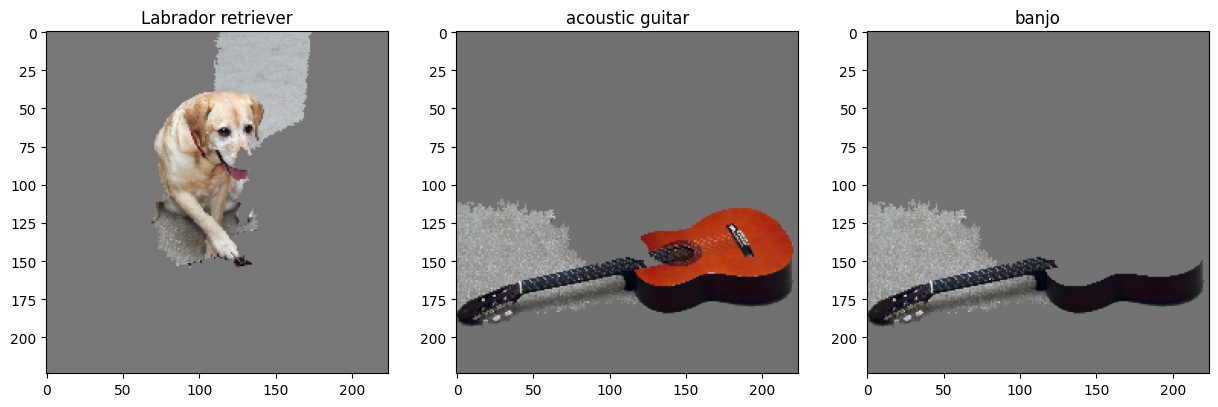

In [41]:
fig, ax = plt.subplots(1,len(top_dog_labels), figsize = (15,6))
for i, (label, index) in enumerate(images_labels[2].items()):
    ax[i].set_title(label)
    ax[i].imshow(results[i]);